In [1]:
# importing packages

import numpy                                                  # Mathematical calculations
import pandas                                                 # Data Visualization
from sklearn.model_selection import train_test_split          # For Training ML Model
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

In [2]:
# To convert database tables to CSV file Format

# import mysql.connector
# import csv

# mydb = mysql.connector.connect(
#   host="project.c1ruqdbfywti.ap-south-1.rds.amazonaws.com",
#   user="admin",
#   passwd="admin1234",
#   database="scoregreat"
# )

# cursor = mydb.cursor()

# cursor.execute("select * from verbal_data;")
# with open("verbal.csv", "w", newline='') as csv_file:            
#     csv_writer = csv.writer(csv_file)
#     csv_writer.writerow([i[0] for i in cursor.description]) #write headers
#     csv_writer.writerows(cursor)

In [3]:
# Assinging both CSV files to respective file objects

math_file = 'mathdata.csv'
verbal_file = 'verbaldata.csv'


# Reading the files into respective Dataframes

math_df = pandas.read_csv(math_file)
verbal_df = pandas.read_csv(verbal_file)

In [4]:
# Data Cleaning

math_df = math_df[math_df.tstamp < 600000]
math_df = math_df[math_df.queid != 0]
verbal_df = verbal_df[verbal_df.tstamp < 600000]
verbal_df = verbal_df[verbal_df.queid != 0]


# Deleting the userid coloumn from both dataframes

del math_df['userid']
del verbal_df['userid']

In [5]:
# Replacing String data into quantifiable data of 'difficulty' coloumn for aggregation purposes

math_df=math_df.replace(to_replace =["very hard","hard","medium","easy"], value =[4,3,2,1])
verbal_df=verbal_df.replace(to_replace =["very hard","hard","medium","easy"], value =[4,3,2,1])


# Sorting the dataframes according to queid coloumn

math_df.sort_values(['queid'], ascending = [True],inplace=True);
verbal_df.sort_values(['queid'], ascending = [True],inplace=True);


# Grouping the data wrt queid and aggregating the coloumns tstamp with mean attribute and result with count attribute

grpm1 = math_df.groupby(['queid']).agg({'tstamp':'mean','result':'count'})
grpv1 = verbal_df.groupby(['queid']).agg({'tstamp':'mean','result':'count'})


# Grouping the data wrt queid and aggregating the coloumn result with sum attribute

grpm2 = math_df.groupby(['queid']).agg({'result':'sum'})
grpv2 = verbal_df.groupby(['queid']).agg({'result':'sum'})


# Grouping the data wrt queid and aggregating the coloumn difficulty with mode attribute

grpm3 = math_df.groupby(['queid']).agg({'difficulty':lambda x:x.value_counts().index[0]})
grpv3 = verbal_df.groupby(['queid']).agg({'difficulty':lambda x:x.value_counts().index[0]})


# Replacing the quantified data of the difficulty coloumn back to its original string equivalent

grpm3=grpm3.replace(to_replace =[4,3,2,1], value =["very hard","hard","medium","easy"])
grpv3=grpv3.replace(to_replace =[4,3,2,1], value =["very hard","hard","medium","easy"])

In [6]:
# Merging the above three dataframes into one dataframe

math_data = pandas.merge(grpm1,grpm2,on="queid",how="left")
math_data.rename(columns = {'result_x':'total_attempts','result_y':'correct_attempts'}, inplace = True)
math_data = pandas.merge(math_data,grpm3,on="queid",how="left")
verbal_data = pandas.merge(grpv1,grpv2,on="queid",how="left")
verbal_data.rename(columns = {'result_x':'total_attempts','result_y':'correct_attempts'}, inplace = True)
verbal_data = pandas.merge(verbal_data,grpv3,on="queid",how="left")

In [7]:
# Removing unwanted abnormalities

math_data = math_data[math_data.correct_attempts != 0]
verbal_data = verbal_data[verbal_data.correct_attempts != 0]

In [8]:
# Adding a coloumn to the dataframe that depicts the percentage of correctness for each question by doing computations on 2 already available coloumns 

math_data['percentage'] = (math_data['correct_attempts'].div(math_data['total_attempts']))*100
verbal_data['percentage'] = (verbal_data['correct_attempts'].div(verbal_data['total_attempts']))*100


# Deleting the non-required coloumns 'corrected_attempts' and 'total_attempts'

del math_data['correct_attempts']
del math_data['total_attempts']
del verbal_data['correct_attempts']
del verbal_data['total_attempts']


# Adding a 'section' coloumn for both dataframes

math_data['section'] = 1
verbal_data['section'] = 2


# Swapping the coloumn positions of 'percentage' and 'difficulty'

columns_titles = ["section","tstamp","percentage","difficulty"]
math_data = math_data.reindex(columns=columns_titles)
verbal_data = verbal_data.reindex(columns=columns_titles)


# Merging the datframes vertically 

data = pandas.concat([math_data, verbal_data],axis=0)


# Adding individual coloumns for math and verbal with initial values 0

data['math'] = 0
data['verbal'] = 0


# If section is math,then math coloumn values becomes 1 and same for if section is verbal 

data.loc[data.section == 1, 'math'] = 1
data.loc[data.section == 2, 'verbal'] = 1


# deleting the now obselete 'section' coloumn
del data['section']

In [10]:
# Creating a seperate dataframe for the target attribute 'difficulty'

# Copying the entire dataframe into another

target = data.copy();


# Removing all the unwanted coloumns
 
del target['math']
del target['verbal']
del target['tstamp']
del target['percentage']


# Creating different coloumns for each distinct value of 'difficulty' attribute with default value 0

target['easy']=0
target['medium']=0
target['hard']=0
target['very hard']=0


# Setting the values of different target values as per values in 'difficulty' coloumn

target.loc[target.difficulty == 'easy', 'easy'] = 1
target.loc[target.difficulty == 'medium', 'medium'] = 1
target.loc[target.difficulty == 'hard', 'hard'] = 1
target.loc[target.difficulty == 'very hard', 'very hard'] = 1


# Deleting the 'difficulty' attribute as it is obselete now

del target['difficulty']
del data['difficulty']

In [11]:
# Printing the final preprocessed data

print("Data to be fed to the model\n\n")
print(data.head())

print("\n\n\nTarget Attribute data\n\n")
print(target.head())

Data to be fed to the model


              tstamp  percentage  math  verbal
queid                                         
1       78225.930556   52.777778     1       0
2       72008.605263   52.631579     1       0
3      116719.025641   53.846154     1       0
4      107408.590909   70.454545     1       0
5       36089.214286   40.476190     1       0



Target Attribute data


       easy  medium  hard  very hard
queid                               
1         0       1     0          0
2         1       0     0          0
3         1       0     0          0
4         1       0     0          0
5         1       0     0          0


In [12]:
# Splitting the data into training and testing data

data_train, data_test, target_train, target_test = train_test_split(data, target,test_size=0.20, random_state=1)



# We have 50 questions to train the model and 13 questions to test it



# Applying Decision Tree Classification Algorithm on the above data
# Creating Object of the class 'DecisionTreeClassifier'
dt = DecisionTreeClassifier()

# Supplying data to classifier object
dt.fit(data_train, target_train)


# Predicting 'difficulty' level for the test data and getting the result a 2-D array

target_pred = dt.predict(data_test)

In [24]:
# Printing the predicted and actual values if the test cases

print("\n\n----------------------------------------------------")
print("Values Predicted by the Classifier of test cases")
print("----------------------------------------------------\n\n")
print(target_pred)

print("\n\n----------------------------------------------------")
print("Original Classes of test cases")
print("----------------------------------------------------\n\n")
print(target_test)


print("\n\nTotal Test Cases: 13")
print("Correctly Predicted Cases: 9")
print("Accuracy : 69%")



----------------------------------------------------
Values Predicted by the Classifier of test cases
----------------------------------------------------


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


----------------------------------------------------
Original Classes of test cases
----------------------------------------------------


       easy  medium  hard  very hard
queid                               
25        0       1     0          0
14        0       1     0          0
26        0       1     0          0
28        1       0     0          0
37        0       0     0          1
3         1       0     0          0
22        1       0     0          0
17        0       0     0          1
16        0       0     0          1
19        0       0     0          1
13        0       1     0          0
28        0       0    

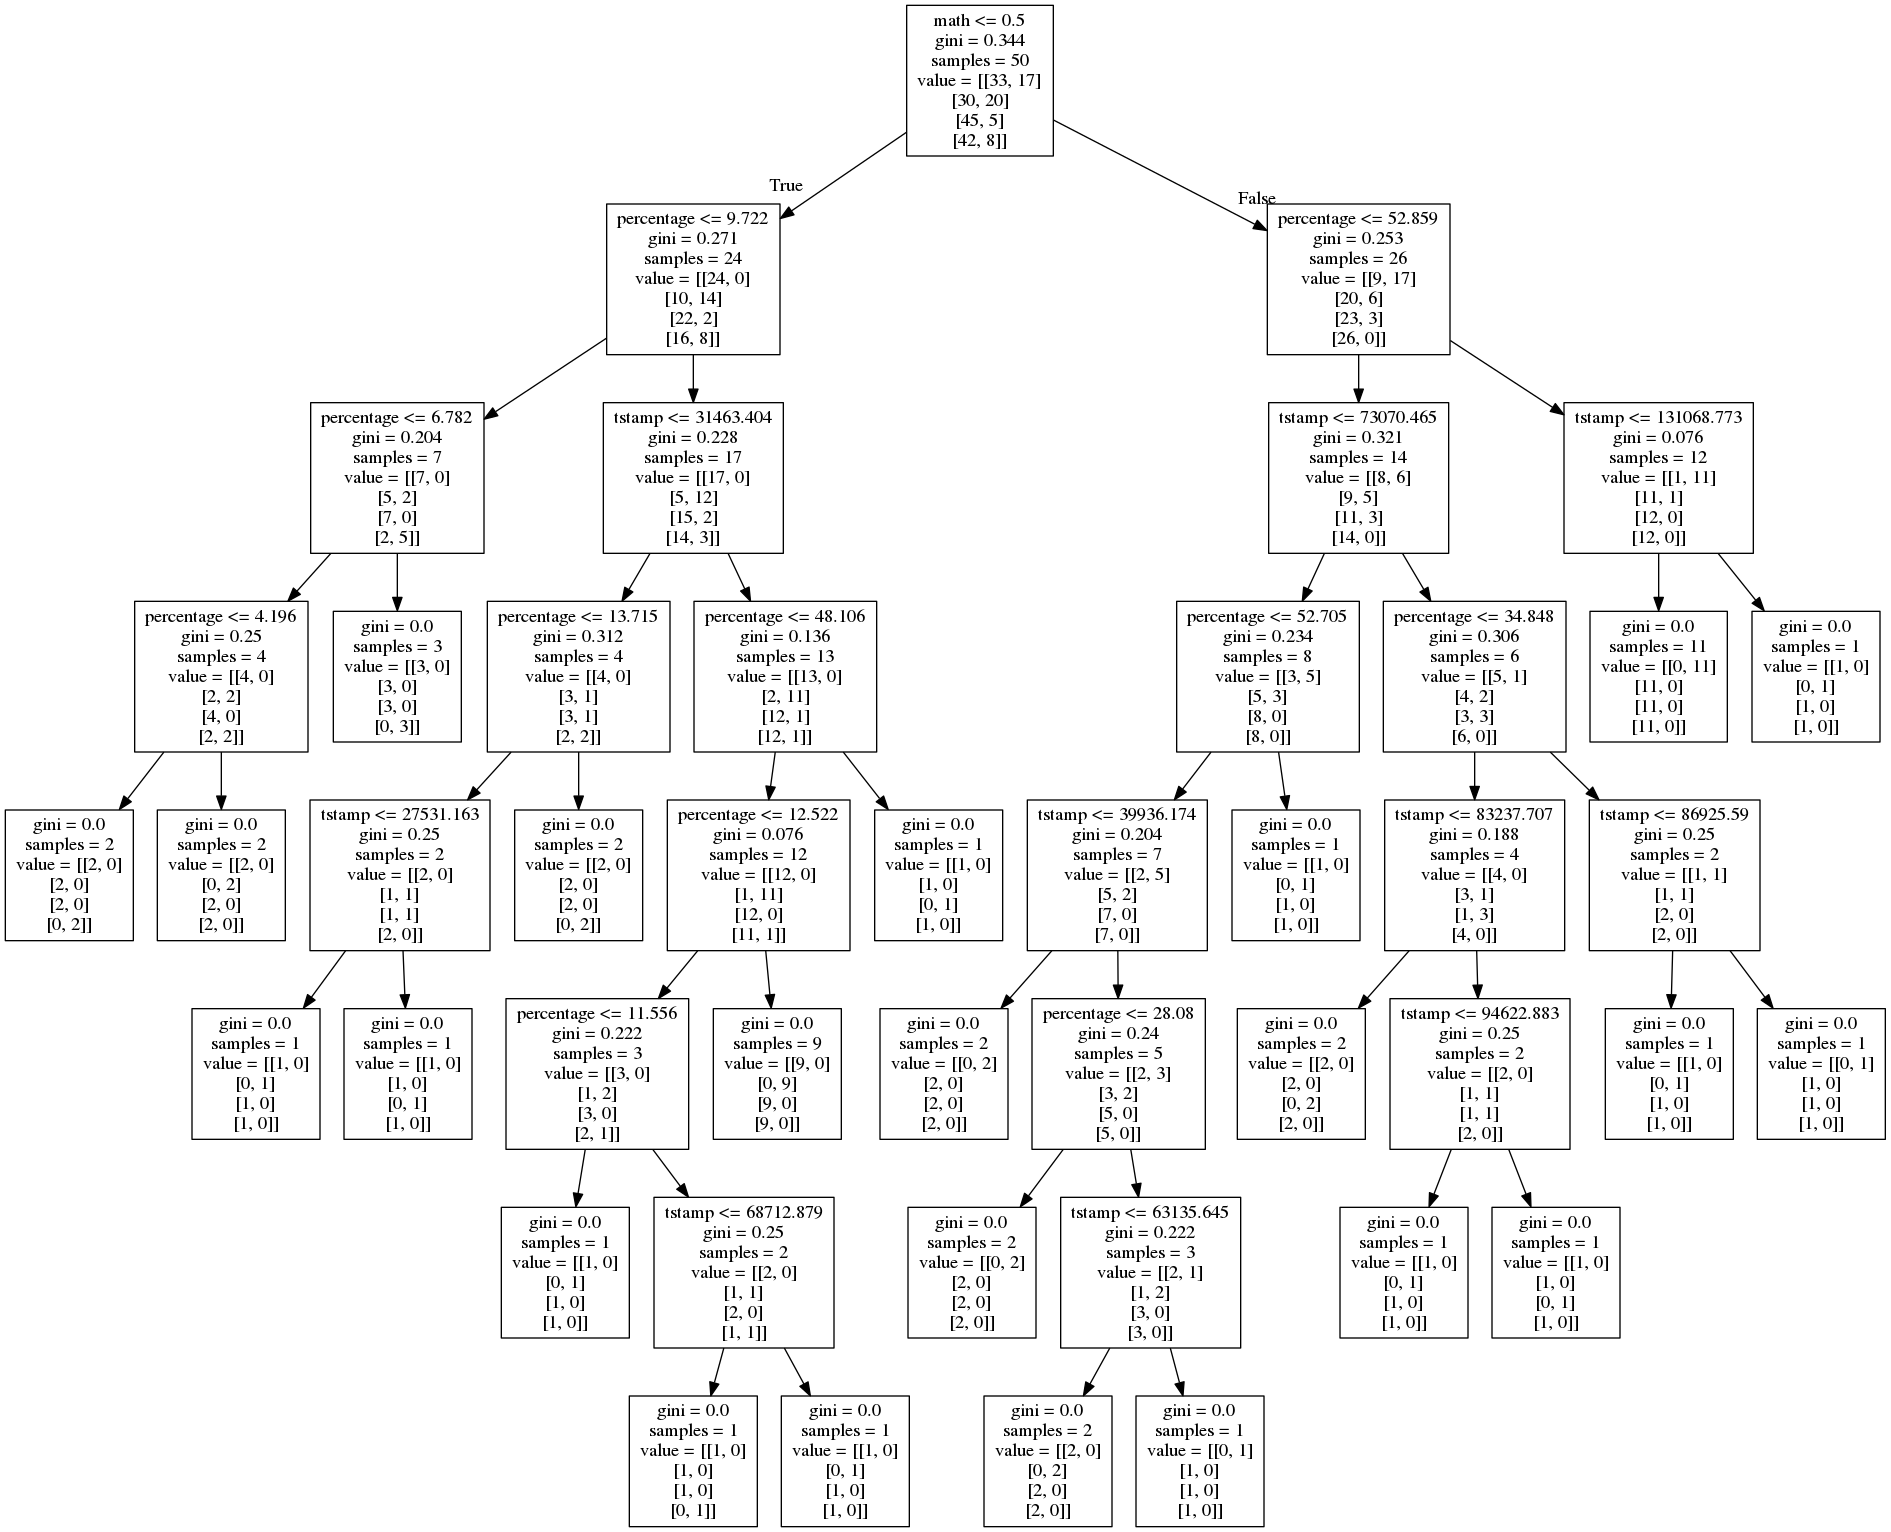

In [14]:
# Pictorial representation of entire Decision Tree 

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, feature_names=data.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())